In [1]:
import pathlib
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import tqdm

sys.path.append("../helpers")

## load data

In [2]:
# load data
cls_file_path = pathlib.Path(
    "../../1.scDINO_analysis/1.scDINO_run/outputdir/mnist_photos/CLS_features/channel_binary_model_dino_deitsmall16_pretrain_full_checkpoint_features.csv"
).resolve(strict=True)

image_paths_file_path = pathlib.Path(
    "../../1.scDINO_analysis/1.scDINO_run/outputdir/mnist_photos/CLS_features/image_paths.csv"
).resolve(strict=True)

# load in the image paths
image_paths = pd.read_csv(image_paths_file_path, header=None)
print(image_paths.shape)

# load in the the data to a csv
cls_features = pd.read_csv(cls_file_path, header=None)
print(cls_features.shape)
cls_features.head()

(1000, 1)
(1000, 384)


,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.014343,-0.056056,-0.011481,-0.055626,0.012334,0.032901,0.032274,-0.000880,0.040455,0.009907,...,-0.012015,0.068037,-0.009617,0.015761,0.029784,0.056326,0.045965,0.079446,0.000861,-0.008884
1,-0.002717,-0.049965,-0.008469,-0.042851,0.004159,0.035253,0.054535,0.005689,0.032905,0.008762,...,0.014834,0.071393,-0.005655,0.001928,0.034038,0.045674,0.033395,0.060793,0.005420,0.000246
2,-0.010738,-0.056532,0.004832,-0.040305,0.013550,-0.003324,0.052629,-0.010052,0.032231,-0.003125,...,0.023953,0.067244,-0.024414,0.007260,0.030100,0.044815,0.038056,0.045523,0.045017,0.003707
3,-0.007631,-0.061167,0.001106,-0.033515,0.017261,-0.020816,0.051166,-0.014052,0.028416,0.005987,...,0.027933,0.071316,-0.034795,0.013045,0.028769,0.028604,0.047432,0.045122,0.061888,0.012887
4,0.001501,-0.051967,-0.002455,-0.024934,0.005073,-0.012239,0.044642,-0.018205,0.021507,0.004976,...,0.034517,0.077356,-0.012682,0.010235,0.023044,0.036613,0.052178,0.033393,0.044812,0.020843


In [3]:
# rename columns
cls_features.columns = [f"CLS_{i}" for i in range(cls_features.shape[1])]
cls_features.head()

,CLS_0,CLS_1,CLS_2,CLS_3,CLS_4,CLS_5,CLS_6,CLS_7,CLS_8,CLS_9,...,CLS_374,CLS_375,CLS_376,CLS_377,CLS_378,CLS_379,CLS_380,CLS_381,CLS_382,CLS_383
0,-0.014343,-0.056056,-0.011481,-0.055626,0.012334,0.032901,0.032274,-0.000880,0.040455,0.009907,...,-0.012015,0.068037,-0.009617,0.015761,0.029784,0.056326,0.045965,0.079446,0.000861,-0.008884
1,-0.002717,-0.049965,-0.008469,-0.042851,0.004159,0.035253,0.054535,0.005689,0.032905,0.008762,...,0.014834,0.071393,-0.005655,0.001928,0.034038,0.045674,0.033395,0.060793,0.005420,0.000246
2,-0.010738,-0.056532,0.004832,-0.040305,0.013550,-0.003324,0.052629,-0.010052,0.032231,-0.003125,...,0.023953,0.067244,-0.024414,0.007260,0.030100,0.044815,0.038056,0.045523,0.045017,0.003707
3,-0.007631,-0.061167,0.001106,-0.033515,0.017261,-0.020816,0.051166,-0.014052,0.028416,0.005987,...,0.027933,0.071316,-0.034795,0.013045,0.028769,0.028604,0.047432,0.045122,0.061888,0.012887
4,0.001501,-0.051967,-0.002455,-0.024934,0.005073,-0.012239,0.044642,-0.018205,0.021507,0.004976,...,0.034517,0.077356,-0.012682,0.010235,0.023044,0.036613,0.052178,0.033393,0.044812,0.020843


In [4]:
# rename the image paths columns
image_paths.columns = ["Metadata_image_paths"]
# make metadata columns for the image paths
cls_features["Metadata_label"] = image_paths["Metadata_image_paths"].apply(
    lambda x: pathlib.Path(x).stem.split("_")[1]
)
cls_features["Metadata_cell_idx"] = image_paths["Metadata_image_paths"].apply(
    lambda x: pathlib.Path(x).stem.split("_")[3]
)
cls_features["Metadata_Time"] = image_paths["Metadata_image_paths"].apply(
    lambda x: pathlib.Path(x).stem.split("_")[5]
)
# reorder the columns so that the metadata columns are first
cls_features = cls_features[
    ["Metadata_label", "Metadata_cell_idx", "Metadata_Time"]
    + cls_features.columns[:-3].tolist()
]

# make all columns floats
cls_features = cls_features.astype(float)
cls_features.head()

,Metadata_label,Metadata_cell_idx,Metadata_Time,CLS_0,CLS_1,CLS_2,CLS_3,CLS_4,CLS_5,CLS_6,...,CLS_374,CLS_375,CLS_376,CLS_377,CLS_378,CLS_379,CLS_380,CLS_381,CLS_382,CLS_383
0,2.0,0.0,0.0,-0.014343,-0.056056,-0.011481,-0.055626,0.012334,0.032901,0.032274,...,-0.012015,0.068037,-0.009617,0.015761,0.029784,0.056326,0.045965,0.079446,0.000861,-0.008884
1,2.0,0.0,1.0,-0.002717,-0.049965,-0.008469,-0.042851,0.004159,0.035253,0.054535,...,0.014834,0.071393,-0.005655,0.001928,0.034038,0.045674,0.033395,0.060793,0.005420,0.000246
2,2.0,0.0,2.0,-0.010738,-0.056532,0.004832,-0.040305,0.013550,-0.003324,0.052629,...,0.023953,0.067244,-0.024414,0.007260,0.030100,0.044815,0.038056,0.045523,0.045017,0.003707
3,2.0,0.0,3.0,-0.007631,-0.061167,0.001106,-0.033515,0.017261,-0.020816,0.051166,...,0.027933,0.071316,-0.034795,0.013045,0.028769,0.028604,0.047432,0.045122,0.061888,0.012887
4,2.0,0.0,4.0,0.001501,-0.051967,-0.002455,-0.024934,0.005073,-0.012239,0.044642,...,0.034517,0.077356,-0.012682,0.010235,0.023044,0.036613,0.052178,0.033393,0.044812,0.020843


In [5]:
# transform the data to a tensor and reshape it based on the timepoints
cls_tensor = torch.tensor(cls_features.iloc[:, 3:].values)
cls_tensor = cls_tensor.reshape(
    -1, cls_features.Metadata_Time.nunique(), cls_tensor.shape[1]
)
cls_tensor.shape

torch.Size([100, 10, 384])

In [20]:
import torch.nn

# make a Dataset
import torch.utils


class CLSDataset(torch.utils.data.Dataset):
    def __init__(self, cls_features: pd.DataFrame):
        super(CLSDataset, self).__init__()
        self.cls_features = cls_features

    def __len__(self):
        return self.cls_features.shape[0]

    @staticmethod
    def mask_timepoints(tensor: torch.Tensor, timepoints: int):
        # mask one timepoint in the tensor
        # random value from 0 to timepoints
        random_timepoint = np.random.randint(0, timepoints)
        tensor[random_timepoint, :] = 1
        return tensor

    def __getitem__(self, idx):
        y = self.cls_features[idx, :, :]
        x = self.mask_timepoints(y, y.shape[0])
        return x, y


# make a DataLoader
cls_dataset = CLSDataset(cls_tensor)
cls_loader = torch.utils.data.DataLoader(cls_dataset, batch_size=20, shuffle=False)
# get the first batch size
x, y = next(iter(cls_loader))
x.shape, y.shape

(torch.Size([20, 10, 384]), torch.Size([20, 10, 384]))

## Define the model

Code adapted from https://medium.com/correll-lab/building-a-vision-transformer-model-from-scratch-a3054f707cc6

In [7]:
class PositionWiseEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()

        self.cls_token = nn.Parameter(
            torch.randn(1, 1, d_model)
        )  # Classification Token

        # Creating positional encoding
        pe = torch.zeros(max_seq_length + 1, d_model)

        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = torch.sin(
                        pos / 10000 ** (2 * i / torch.tensor(d_model))
                    )
                else:
                    pe[pos][i] = torch.cos(
                        pos / 10000 ** (2 * i / torch.tensor(d_model))
                    )

        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        # Expand to have class token for every image in batch
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

        # Adding class tokens to the beginning of each embedding
        x = torch.cat((tokens_batch, x), dim=1)

        # Add positional encoding to embeddings
        x = x + self.pe[:, : x.size(1), :]

        return x


# test the PositionWiseEncoding
d_model = torch.tensor(512)
max_seq_length = torch.tensor(10)
pe = PositionWiseEncoding(d_model, max_seq_length)
pe.forward(torch.randn(2, 10, 512))

/tmp/ipykernel_1414745/3546248156.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pe[pos][i] = torch.sin(pos / 10000 ** (2 * i / torch.tensor(d_model)))
/tmp/ipykernel_1414745/3546248156.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pe[pos][i] = torch.cos(pos / 10000 ** (2 * i / torch.tensor(d_model)))


tensor([[[-0.1888, -0.6105,  0.7910,  ...,  0.6690, -1.4179,  2.7254],
         [ 1.2380,  0.3049,  0.6959,  ...,  0.4081, -0.0066, -0.3092],
         [ 2.3123,  0.0965,  1.1800,  ...,  0.0573,  1.0188, -1.2512],
         ...,
         [ 2.7200, -0.3745,  1.8364,  ...,  1.0358,  1.3479,  0.5753],
         [-0.6890, -1.5859,  0.7158,  ...,  2.4113,  0.2104, -0.1971],
         [ 0.7154, -0.0967, -1.0232,  ...,  1.4754,  1.3952,  1.1759]],

        [[-0.1888, -0.6105,  0.7910,  ...,  0.6690, -1.4179,  2.7254],
         [ 1.2411,  0.8458,  0.9075,  ...,  1.6623,  1.6718,  0.9614],
         [ 2.5008,  0.9108,  2.0965,  ..., -0.5698,  0.5802,  0.3667],
         ...,
         [ 2.2027, -1.3510,  0.7645,  ...,  0.6021,  1.3272,  0.1543],
         [ 1.2930, -1.9828,  2.4028,  ..., -0.8704,  0.0491,  1.2405],
         [ 0.5402, -0.9872, -0.4195,  ...,  0.3705,  2.7086,  0.4780]]],
       grad_fn=<AddBackward0>)

In [8]:
class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.head_size = head_size

        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, x):
        # Obtaining Queries, Keys, and Values
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Dot Product of Queries and Keys
        attention = Q @ K.transpose(-2, -1)

        # Scaling
        attention = attention / (self.head_size**0.5)

        attention = torch.softmax(attention, dim=-1)

        attention = attention @ V

        return attention


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.head_size = d_model // n_heads

        self.W_o = nn.Linear(d_model, d_model)

        self.heads = nn.ModuleList(
            [AttentionHead(d_model, self.head_size) for _ in range(n_heads)]
        )

    def forward(self, x):
        # Combine attention heads
        out = torch.cat([head(x) for head in self.heads], dim=-1)

        out = self.W_o(out)

        return out


# test the MultiHeadAttention
d_model = torch.tensor(512)
n_heads = torch.tensor(8)
mha = MultiHeadAttention(d_model, n_heads)
mha.forward(torch.randn(2, 10, 512))

tensor([[[ 0.0613, -0.0091,  0.0132,  ...,  0.0079, -0.0105,  0.0348],
         [ 0.1724, -0.0121,  0.0268,  ...,  0.0035,  0.0052,  0.0278],
         [ 0.0740,  0.0547,  0.0264,  ..., -0.0006, -0.0478,  0.0310],
         ...,
         [ 0.0804,  0.0337,  0.0774,  ..., -0.0369, -0.0448, -0.0110],
         [ 0.0704, -0.0097,  0.0765,  ...,  0.0030, -0.0730,  0.0076],
         [ 0.0526,  0.0504,  0.0478,  ..., -0.0548, -0.0176, -0.0166]],

        [[ 0.0134, -0.3185, -0.1437,  ..., -0.0380, -0.0369,  0.0716],
         [-0.0083, -0.3161, -0.1575,  ..., -0.0648, -0.0171,  0.0887],
         [-0.0575, -0.2965, -0.1710,  ..., -0.0112,  0.0114,  0.0663],
         ...,
         [-0.0085, -0.3037, -0.2149,  ...,  0.0165, -0.0349,  0.1222],
         [-0.0326, -0.2947, -0.1794,  ..., -0.0850, -0.0162,  0.1520],
         [-0.0122, -0.3201, -0.1767,  ..., -0.1083, -0.0542,  0.1011]]],
       grad_fn=<ViewBackward0>)

In [9]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        # Sub-Layer 1 Normalization
        self.ln1 = nn.LayerNorm(d_model)

        # Multi-Head Attention
        self.mha = MultiHeadAttention(d_model, n_heads)

        # Sub-Layer 2 Normalization
        self.ln2 = nn.LayerNorm(d_model)

        # Multilayer Perception
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model),
        )

    def forward(self, x):
        # Residual Connection After Sub-Layer 1
        out = x + self.mha(self.ln1(x))

        # Residual Connection After Sub-Layer 2
        out = out + self.mlp(self.ln2(out))

        return out


# test the TransformerEncoder
d_model = 384
n_heads = 8
r_mlp = 4
te = TransformerEncoder(d_model, n_heads, r_mlp)
te.forward(torch.randn(2, 10, 384, dtype=torch.float32))

tensor([[[ 0.2275, -1.0103, -0.6113,  ...,  0.0272, -0.6759,  1.8072],
         [-0.3188, -0.6328,  0.7344,  ..., -0.7466, -0.7455,  0.0601],
         [-0.2324,  0.2861,  0.2718,  ..., -0.4982,  2.6236, -0.6789],
         ...,
         [ 0.4092,  1.0917, -1.8892,  ..., -0.0288, -0.1848,  0.0385],
         [-0.4962,  3.9384, -1.2378,  ...,  0.1001, -0.2927, -0.0375],
         [-0.5033, -0.2665, -0.0328,  ...,  1.2296, -0.1386,  0.6877]],

        [[ 0.1897, -0.2294,  0.0373,  ..., -0.0553,  0.9355,  0.7137],
         [ 1.1126, -1.1757, -2.2004,  ..., -1.5176, -1.5588, -1.9119],
         [-0.1871, -2.7521, -0.6431,  ...,  0.9893, -1.2528, -0.4713],
         ...,
         [-1.1013,  1.5379, -0.9663,  ...,  0.7369, -0.4908, -0.9410],
         [-0.3856,  1.7095,  0.4964,  ...,  0.1140, -0.2935, -1.6694],
         [-1.5620,  0.5602, -0.3023,  ..., -0.0954,  1.6424,  1.5606]]],
       grad_fn=<AddBackward0>)

In [10]:
class TemporalTransformer(nn.Module):
    def __init__(self, d_model, n_classes, n_heads, n_layers, seq_len):
        super().__init__()

        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model  # Dimensionality of model
        self.n_classes = n_classes  # Number of classes
        self.n_heads = n_heads  # Number of attention heads
        self.seq_len = seq_len  # Sequence length

        self.positional_encoding = PositionWiseEncoding(self.d_model, self.seq_len)
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)]
        )

        # Classification MLP
        self.classifier = nn.Sequential(
            nn.Linear(self.d_model, self.n_classes), nn.Softmax(dim=-1)
        )

    def forward(self, x):

        x = self.positional_encoding(x)

        x = self.transformer_encoder(x)

        # x = self.classifier(x[:,0])
        # remove the class token
        x = x[:, 1:, :]

        return x


# test the Transformer
d_model = 384
n_classes = 10
n_heads = 8
n_layers = 4
seq_len = 10
tt = TemporalTransformer(d_model, n_classes, n_heads, n_layers, seq_len)
tt.forward(torch.randn(2, 10, 384))

tensor([[[ 0.7536,  0.4999, -1.1799,  ...,  1.2616,  1.8426,  2.0669],
         [-1.1991,  0.3200,  2.4884,  ..., -0.0641,  0.7043,  3.0285],
         [ 0.2082, -1.0938,  1.3878,  ...,  0.9374, -0.7414,  1.0811],
         ...,
         [-0.9802, -0.3091, -1.1818,  ...,  0.0812, -0.7069,  1.0407],
         [-1.0149, -1.0883,  0.4896,  ...,  1.9288, -0.3183, -1.1532],
         [-2.1372, -0.2802, -0.1112,  ..., -1.0198,  0.8749,  1.8659]],

        [[-0.6363,  1.2621, -1.0156,  ...,  1.0461, -0.1059,  0.1495],
         [-0.1141,  0.5562,  1.7125,  ...,  2.5072, -0.1786,  4.1357],
         [ 0.0275, -1.6148,  0.2428,  ..., -0.9461,  2.1312,  0.2944],
         ...,
         [-0.8605,  0.2592,  2.0459,  ...,  1.4273, -0.6774, -0.4111],
         [-0.8926, -0.6644, -1.6724,  ...,  1.2438,  0.1506,  1.5056],
         [ 0.4276,  0.1604, -1.6966,  ...,  0.0093, -0.0111,  2.4047]]],
       grad_fn=<SliceBackward0>)

## Test the model

In [11]:
d_model = 384
n_classes = 10
n_heads = 4
n_layers = 3
batch_size = 4
epochs = 100
alpha = 0.005

seq_len = 10
# training data loader is cls_loader

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    "Using device: ",
    device,
    f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "",
)

transformer = TemporalTransformer(d_model, n_classes, n_heads, n_layers, seq_len).to(
    device
)
# import adam
from torch.optim import Adam

optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.MSELoss()

for epoch in range(epochs):

    training_loss = 0.0
    for i, data in enumerate(cls_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device).float(), labels.to(device).float()
        optimizer.zero_grad()
        outputs = transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs} loss: {training_loss  / len(cls_loader) :.3f}")

Using device:  cuda (NVIDIA GeForce RTX 3090 Ti)
Epoch 1/100 loss: 21.970
Epoch 2/100 loss: 1.586
Epoch 3/100 loss: 0.214
Epoch 4/100 loss: 0.131
Epoch 5/100 loss: 0.102
Epoch 6/100 loss: 0.076
Epoch 7/100 loss: 0.059
Epoch 8/100 loss: 0.052
Epoch 9/100 loss: 0.061
Epoch 10/100 loss: 0.053
Epoch 11/100 loss: 0.048
Epoch 12/100 loss: 0.038
Epoch 13/100 loss: 0.034
Epoch 14/100 loss: 0.032
Epoch 15/100 loss: 0.042
Epoch 16/100 loss: 0.025
Epoch 17/100 loss: 0.022
Epoch 18/100 loss: 0.022
Epoch 19/100 loss: 0.044
Epoch 20/100 loss: 0.150
Epoch 21/100 loss: 0.088
Epoch 22/100 loss: 0.024
Epoch 23/100 loss: 0.011
Epoch 24/100 loss: 0.008
Epoch 25/100 loss: 0.007
Epoch 26/100 loss: 0.006
Epoch 27/100 loss: 0.005
Epoch 28/100 loss: 0.005
Epoch 29/100 loss: 0.004
Epoch 30/100 loss: 0.004
Epoch 31/100 loss: 0.004
Epoch 32/100 loss: 0.004
Epoch 33/100 loss: 0.004
Epoch 34/100 loss: 0.004
Epoch 35/100 loss: 0.004
Epoch 36/100 loss: 0.004
Epoch 37/100 loss: 0.003
Epoch 38/100 loss: 0.003
Epoch 39/

In [13]:
correct = 0
total = 0
list_of_reconstructed = []
list_of_original = []
with torch.no_grad():
    for data in cls_loader:
        x, y = data
        x, y = x.to(device).float(), y.to(device).float()

        # reshape (B, T, d) -> (B*T, d)
        x = transformer(x)
        x = x.reshape(-1, x.shape[-1])
        y = y.reshape(-1, y.shape[-1])
        list_of_reconstructed.append(x.cpu().numpy())
        list_of_original.append(y.cpu().numpy())

In [14]:
# make two different dfs for the reconstructed and original data
reconstructed_df = pd.DataFrame(np.concatenate(list_of_reconstructed))
original_df = pd.DataFrame(np.concatenate(list_of_original))

# add the metadata columns
reconstructed_df = pd.concat([cls_features.iloc[:, :3], reconstructed_df], axis=1)
original_df = pd.concat([cls_features.iloc[:, :3], original_df], axis=1)

# add label for reconstructed and original
reconstructed_df["Metadata_reconstructed"] = "reconstructed_df"
original_df["Metadata_reconstructed"] = "original_df"

# combine the two dataframes
combined_df = pd.concat([reconstructed_df, original_df])
combined_df.head()
# rename columns if int columns
combined_df.rename(
    columns={
        col: f"CLS_{col}" if isinstance(col, int) else col
        for col in combined_df.columns
    },
    inplace=True,
)
# metadata columns
metadata_columns = [col for col in combined_df.columns if "Metadata" in col]
combined_df.reset_index(drop=True, inplace=True)
features_df = combined_df.drop(metadata_columns, axis=1)

features_df.head()

,CLS_0,CLS_1,CLS_2,CLS_3,CLS_4,CLS_5,CLS_6,CLS_7,CLS_8,CLS_9,...,CLS_374,CLS_375,CLS_376,CLS_377,CLS_378,CLS_379,CLS_380,CLS_381,CLS_382,CLS_383
0,1.641632,1.645462,1.520584,1.480106,1.663513,1.659119,1.595978,1.778687,1.524292,1.830261,...,1.294083,0.957703,0.925049,1.100655,1.050323,0.985596,1.162064,0.813431,1.169556,1.171326
1,1.719177,0.709534,1.730789,0.697472,1.905884,0.953400,1.903320,1.152893,1.869263,1.304016,...,1.239456,0.968201,0.937149,1.072411,1.035950,0.978455,1.159897,0.842560,1.099030,1.180389
2,0.988892,0.026154,1.217606,0.047493,1.507568,0.241989,1.706116,0.459900,1.802307,0.688904,...,1.129608,0.993652,0.968964,1.021667,1.015976,0.980652,1.142899,0.892517,1.024319,1.148499
3,0.128845,0.155075,0.389236,0.001144,0.711304,-0.062149,1.106873,0.030060,1.358582,0.229706,...,0.999832,1.024536,1.007828,0.968735,0.994110,0.987183,1.099747,0.957581,0.962524,1.081635
4,-0.073578,0.978180,-0.107758,0.607277,0.019531,0.213791,0.424774,0.065979,0.746094,0.108734,...,0.892502,1.045227,1.037735,0.936722,0.978271,0.994507,1.027206,1.027252,0.926231,0.995422


In [15]:
# umap
import umap

reducer = umap.UMAP(n_neighbors=15, n_components=2, metric="euclidean")
embedding = reducer.fit_transform(features_df)
embedding_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
embedding_df["Metadata_reconstructed"] = combined_df["Metadata_reconstructed"]
embedding_df["Metadata_label"] = combined_df["Metadata_label"]
embedding_df["Metadata_cell_idx"] = combined_df["Metadata_cell_idx"]
embedding_df.head()

/home/lippincm/miniforge3/envs/transformers_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lippincm/miniforge3/envs/transformers_env/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


,UMAP1,UMAP2,Metadata_reconstructed,Metadata_label,Metadata_cell_idx
0,20.991087,20.170084,reconstructed_df,2.0,0.0
1,5.847799,31.114540,reconstructed_df,2.0,0.0
2,26.004248,13.182863,reconstructed_df,2.0,0.0
3,12.711978,10.045938,reconstructed_df,2.0,0.0
4,5.904071,18.985582,reconstructed_df,2.0,0.0


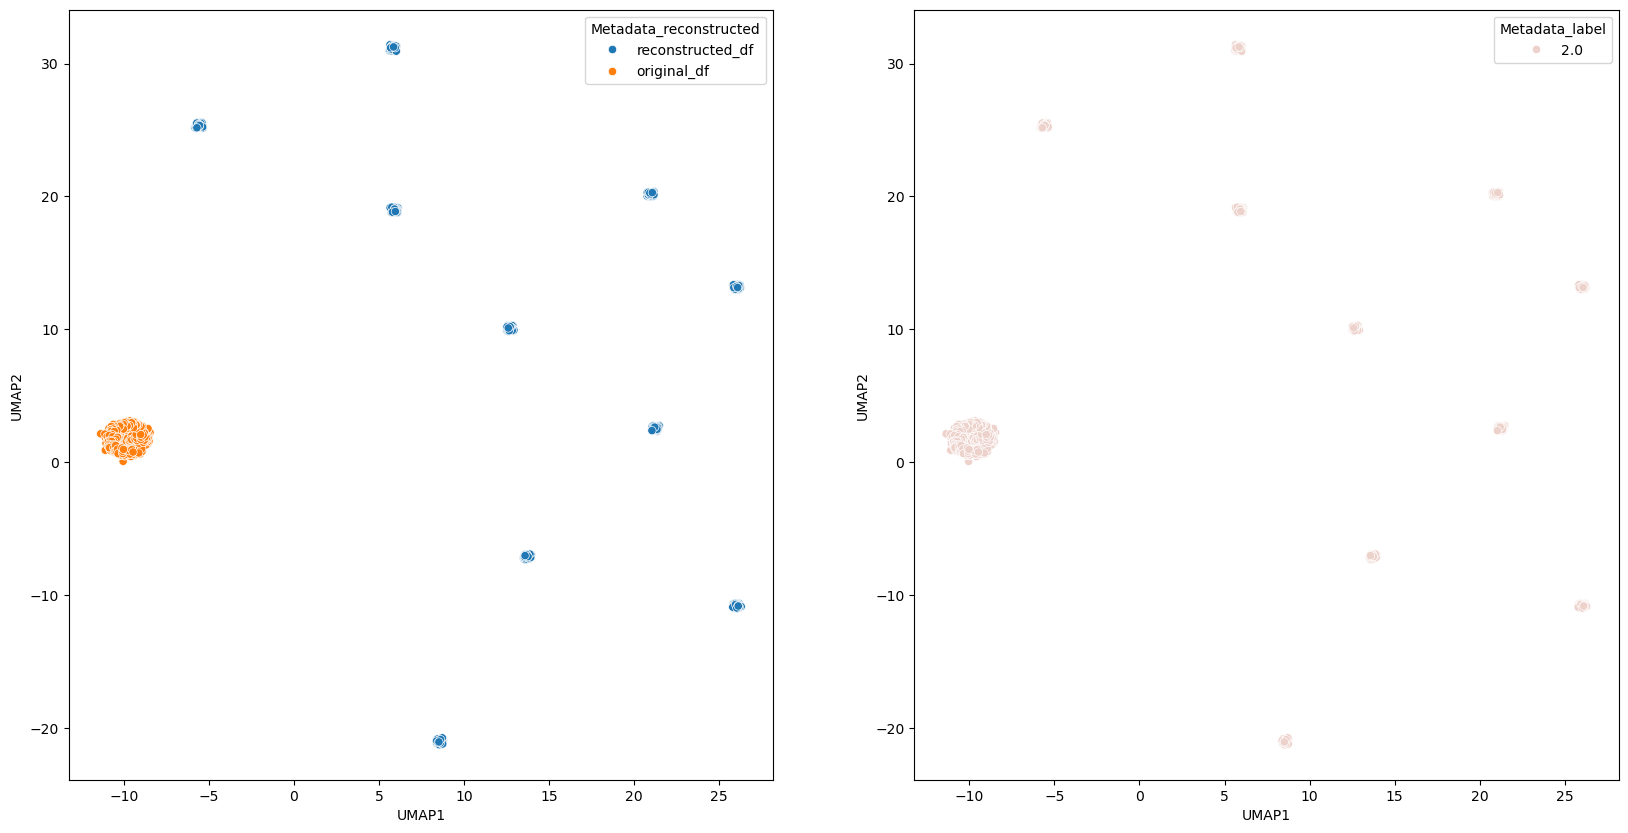

In [19]:
# plot the umap
import matplotlib.pyplot as plt
import seaborn as sns

# two subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(
    data=embedding_df, x="UMAP1", y="UMAP2", hue="Metadata_reconstructed", ax=ax[0]
)
sns.scatterplot(data=embedding_df, x="UMAP1", y="UMAP2", hue="Metadata_label", ax=ax[1])
plt.show()